In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import datetime as dt

In [2]:
twitter_df = pd.read_csv('twitter.csv')
twitter_loc_df = twitter_df[~twitter_df.location.isna()]
twitter_loc_df.head()

,id,author_id,timestamp,text,search_term,location,coordinates,sentiment,gcc,topic,year,month,day,hour,week,state
7,1516166460426665992,961128374751125505,2022-04-18 21:27:07,@deemadigan Geez they had to add some nonsense...,inflation,"Melbourne, Victoria",NaN,0.239130,2gmel,inflation,2022,4,18,21,16,vic
31,1546691617767424000,907645652,2022-07-12 03:03:12,Internal pictures have no captions or identifi...,housing,"Sydney, New South Wales",NaN,0.032258,1gsyd,housing,2022,7,12,3,28,nsw
49,1521432446029680640,826332877457481728,2022-05-03 10:12:16,@spiritgateoz @ricklevy67 @ScottMorrisonMP @Al...,housing,"Adelaide, South Australia",NaN,0.181818,4gade,housing,2022,5,3,10,18,sa
64,1539149240379019264,3107950518,2022-06-21 07:32:29,@BlytheByName @KerrieT35027863 Because politic...,jobseeker,"Hobart, Tasmania",NaN,-0.032258,6ghob,social security,2022,6,21,7,25,tas
81,1525816337104515073,14241904,2022-05-15 12:32:17,@Just_Westy @TroyBramston Yes. Like negative g...,housing,"Brisbane, Queensland",NaN,-0.055556,3gbri,housing,2022,5,15,12,19,qld


In [3]:
twitter_loc_agg_df = twitter_loc_df.groupby(['gcc','topic']).agg({'id':'count','author_id':'nunique'}).reset_index().sort_values('gcc')
twitter_loc_agg_df = twitter_loc_agg_df.pivot('gcc','topic','author_id').reset_index()
twitter_loc_agg_df.rename(columns={'housing':'housing_tws',
                           'inflation':'inflation_tws',
                           'interest rate':'interest_rate_tws',
                           'social security':'social_security_tws',
                           'gcc':'gccsa'}, inplace=True)
twitter_loc_agg_df.head(15)

topic,gccsa,housing_tws,inflation_tws,interest_rate_tws,social_security_tws
0,1gsyd,283,260,165,113
1,1rnsw,97,67,36,47
2,2gmel,305,268,150,121
3,2rvic,49,44,19,28
4,3gbri,130,103,62,53
5,3rqld,122,100,47,36
6,4gade,72,63,35,30
7,4rsau,11,7,6,5
8,5gper,98,76,48,33
9,5rwau,14,16,5,3


In [7]:
housing_totals_df = pd.read_csv('data_GCCSA/sudo_gccsa_housing_totals_2016.csv')
housing_totals_df['gcc_code16'] = housing_totals_df['gcc_code16'].str.lower()
housing_totals_df.rename(columns={'gcc_code16':'gccsa'}, inplace=True)
income_avg_df = pd.read_csv('data_GCCSA/sudo_gccsa_income_mortgage_rent_avg_2016.csv')
income_avg_df['gcc_code16'] = income_avg_df['gcc_code16'].str.lower()
income_avg_df.rename(columns={'gcc_code16':'gccsa'}, inplace=True)
inequality_df = pd.read_csv('data_GCCSA/sudo_gccsa_inequality_2017.csv')
inequality_df['gccsa_code'] = inequality_df['gccsa_code'].str.lower()
inequality_df.rename(columns={'gccsa_code':'gccsa'}, inplace=True)

In [8]:
housing_totals_df.head()

,gccsa,gcc_name16,rent_total,own_mortgage_total,own_outright_total
0,1gsyd,Greater Sydney,553249,539917,472635
1,1rnsw,Rest of NSW,273674,300087,367033
2,2gmel,Greater Melbourne,472462,567574,479374
3,2rvic,Rest of Vic.,134890,178924,203317
4,3gbri,Greater Brisbane,272751,281867,208811


In [9]:
combined_df = pd.merge(twitter_loc_agg_df, housing_totals_df.drop('gcc_name16',axis=1), on='gccsa', how='inner')
combined_df = pd.merge(combined_df, income_avg_df[['gccsa',
                                                   'median_tot_hhd_inc_weekly',
                                                   'median_mortgage_repay_monthly']], on='gccsa', how='inner')
combined_df = pd.merge(combined_df, inequality_df[['gccsa',
                                                   'median_age_of_earners_years',
                                                   'earners_persons',
                                                   'gini_coefficient_coef']], on='gccsa', how='inner')
combined_df.head()                                                  

,gccsa,housing_tws,inflation_tws,interest_rate_tws,social_security_tws,rent_total,own_mortgage_total,own_outright_total,median_tot_hhd_inc_weekly,median_mortgage_repay_monthly,median_age_of_earners_years,earners_persons,gini_coefficient_coef
0,1gsyd,283,260,165,113,553249,539917,472635,1750,2167,40,2909201,0.493
1,1rnsw,97,67,36,47,273674,300087,367033,1168,1590,45,1435100,0.470
2,2gmel,305,268,150,121,472462,567574,479374,1542,1800,40,2671373,0.483
3,2rvic,49,44,19,28,134890,178924,203317,1124,1300,45,802387,0.464
4,3gbri,130,103,62,53,272751,281867,208811,1562,1861,40,1347196,0.464


In [10]:
for col in combined_df.columns:
    if col in ['housing_tws','inflation_tws','interest_rate_tws','social_security_tws']:
        combined_df[f'{col}_pc'] = combined_df[col]/combined_df.earners_persons*100_000
for col in combined_df.columns:
    if col in ['rent_total','own_mortgage_total','own_outright_total']:
        combined_df[f'{col}_pc'] = combined_df[col]/combined_df.earners_persons

In [11]:
combined_df['rural_urban'] = ['U','R','U','R','U','R','U','R','U','R','U','R','U','R','U']

In [12]:
combined_df.columns

Index(['gccsa', 'housing_tws', 'inflation_tws', 'interest_rate_tws',
       'social_security_tws', 'rent_total', 'own_mortgage_total',
       'own_outright_total', 'median_tot_hhd_inc_weekly',
       'median_mortgage_repay_monthly', 'median_age_of_earners_years',
       'earners_persons', 'gini_coefficient_coef', 'housing_tws_pc',
       'inflation_tws_pc', 'interest_rate_tws_pc', 'social_security_tws_pc',
       'rent_total_pc', 'own_mortgage_total_pc', 'own_outright_total_pc',
       'rural_urban'],
      dtype='object')

In [13]:
corr_matrix = combined_df[[col for col in combined_df.columns if 'tws_pc' in col]].corr().to_string()
print(corr_matrix)

                        housing_tws_pc  inflation_tws_pc  interest_rate_tws_pc  social_security_tws_pc
housing_tws_pc                1.000000          0.881465              0.248801                0.730062
inflation_tws_pc              0.881465          1.000000              0.355722                0.651058
interest_rate_tws_pc          0.248801          0.355722              1.000000                0.161357
social_security_tws_pc        0.730062          0.651058              0.161357                1.000000


(-0.4215552858262992, 0.11757744353141265)


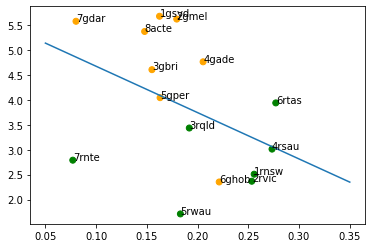

In [35]:
x = combined_df['own_outright_total_pc']
y = combined_df['interest_rate_tws_pc']
c = combined_df['rural_urban'].map({'R':'green', 'U':'orange'})

results = sm.OLS(y,sm.add_constant(x)).fit()

plt.scatter(x, y, c=c)
for i, txt in enumerate(combined_df['gccsa']):
    plt.annotate(txt, (x[i], y[i]))

X_plot = np.linspace(0.05,0.35,100)
plt.plot(X_plot, X_plot * results.params[1] + results.params[0])
    
print(pearsonr(x, y))

(0.6136660003833199, 0.014963545898507393)


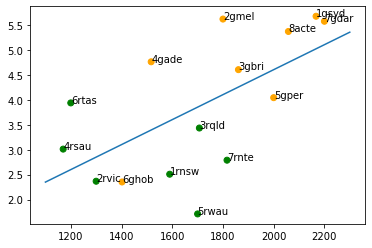

In [36]:
#1

x = combined_df['median_mortgage_repay_monthly']
y = combined_df['interest_rate_tws_pc']
c = combined_df['rural_urban'].map({'R':'green', 'U':'orange'})

results = sm.OLS(y,sm.add_constant(x)).fit()

plt.scatter(x, y, c=c)
for i, txt in enumerate(combined_df['gccsa']):
    plt.annotate(txt, (x[i], y[i]))

X_plot = np.linspace(1100,2300,100)
plt.plot(X_plot, X_plot * results.params[1] + results.params[0])
    
print(pearsonr(x, y))

In [16]:
interest_df = pd.read_csv('data_GCCSA/rba_target_cash_rate.csv')
interest_df['date'] = pd.to_datetime(interest_df['date'], format="%d/%m/%Y")
interest_df['week'] = interest_df['date'].dt.isocalendar().week
interest_df['month'] = interest_df['date'].dt.month
interest_sample_df = interest_df[(interest_df['date']>=dt.datetime(2022,2,10))&(interest_df['date']<=dt.datetime(2022,8,10))]
interest_sample_df = interest_sample_df.groupby('week').agg({'target_cash_rate':'max'}).reset_index()

inflation_df = pd.read_csv('data_GCCSA/inflation.csv')
inflation_df['date'] = pd.to_datetime(inflation_df['date'], format="%d/%m/%Y")
inflation_df['month'] = inflation_df['date'].dt.month
inflation_sample_df = inflation_df[(inflation_df['date']>=dt.datetime(2022,2,1))&(inflation_df['date']<=dt.datetime(2022,8,10))]
inflation_sample_df = pd.merge(interest_df[['date','week','month']], inflation_sample_df[['month','cpi']], on='month')
inflation_sample_df = inflation_sample_df.drop_duplicates('week')
inflation_sample_df = inflation_sample_df[(inflation_sample_df['week']>5)&(inflation_sample_df['week']<33)].reset_index()

<ipython-input-17-c84727c8d2a0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])


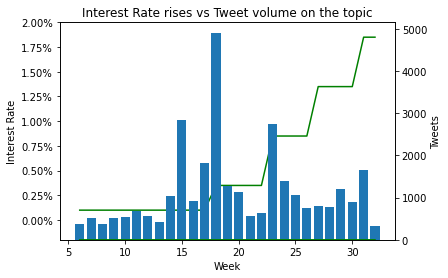

In [17]:
weekly_tweets_df = twitter_df[twitter_df['topic']=='interest rate'].groupby('week').agg({'id':'count'}).reset_index().sort_values('week')

fig, ax1 = plt.subplots()
ax1.set_ylabel('Interest Rate')
ax1.set_xlabel('Week')
ax1.plot(interest_sample_df.week, interest_sample_df.target_cash_rate, color='green')
ax1.set_ylim([-0.002, 0.02])
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])

ax2 = ax1.twinx()
ax2.bar(weekly_tweets_df.week,weekly_tweets_df.id)
ax2.set_ylabel('Tweets')
ax2.plot(interest_sample_df.week, interest_sample_df.target_cash_rate, color='green')

plt.title('Interest Rate rises vs Tweet volume on the topic')
plt.show()

<ipython-input-18-b2591d2dfdc8>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])


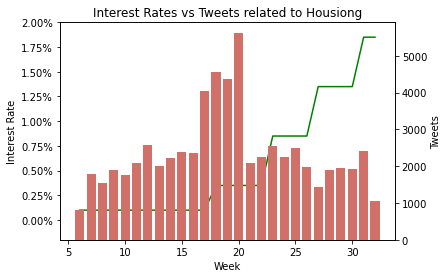

In [18]:
weekly_tweets_df = twitter_df[twitter_df['topic']=='housing'].groupby('week').agg({'id':'count'}).reset_index().sort_values('week')
fig, ax1 = plt.subplots()
ax1.set_ylabel('Interest Rate')
ax1.set_xlabel('Week')
ax1.plot(interest_sample_df.week, interest_sample_df.target_cash_rate, color='green')
ax1.set_ylim([-0.002, 0.02])
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])

ax2 = ax1.twinx()
ax2.bar(weekly_tweets_df.week,weekly_tweets_df.id, color='#d16f69')
ax2.set_ylabel('Tweets')

plt.title('Interest Rates vs Tweets related to Housiong')
plt.show()

<ipython-input-19-fe16acd46c28>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])


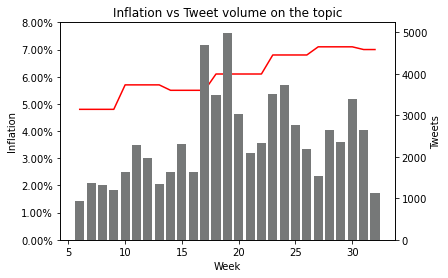

In [19]:
weekly_tweets_df = twitter_df[twitter_df['topic']=='inflation'].groupby('week').agg({'id':'count'}).reset_index().sort_values('week')
fig, ax1 = plt.subplots()

ax1.plot(list(inflation_sample_df.week), list(inflation_sample_df.cpi), color='red')
ax1.set_ylabel('Inflation')
ax1.set_xlabel('Week')
ax1.set_ylim([-0.00, 0.08])
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in ax1.get_yticks()])


ax2 = ax1.twinx()
ax2.bar(weekly_tweets_df.week,weekly_tweets_df.id, color='#767878')
ax2.set_ylabel('Tweets')

plt.title('Inflation vs Tweet volume on the topic')
plt.show()

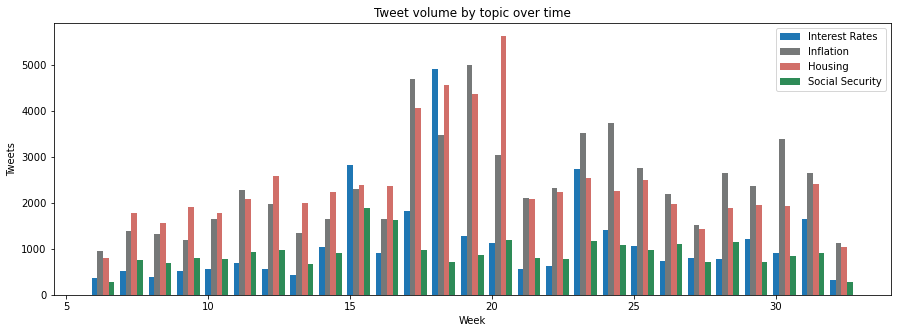

In [21]:
data = twitter_df.groupby(['week','topic']).agg({'id':'count'}).reset_index().pivot('week','topic','id').reset_index()
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
width = 0.2
ax.bar(data.week, data['interest rate'], width=width, label='Interest Rates')
ax.bar(data.week+width, data.inflation, width=width, color='#767878', label='Inflation')
ax.bar(data.week+width*2, data.housing, width=width, color='#d16f69', label='Housing')
ax.bar(data.week+width*3, data['social security'], width=width, color='seagreen', label='Social Security')
ax.set_title('Tweet volume by topic over time')
ax.set_xlabel('Week')
ax.set_ylabel('Tweets')

#ax.set_xticks(data.week+width*2, tuple(data.week))
ax.legend()
plt.show()

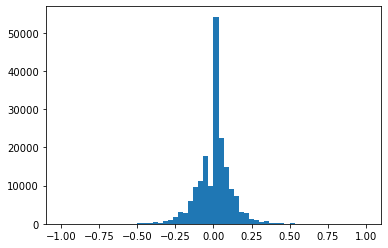

In [29]:
plt.hist(twitter_df.sentiment, bins=60, range=(-1,1))
plt.show()